# **Imbalanced Data Iris**

## 1. Muat Data

Tahap pertama adalah memuat dataset Iris dari file `iris.csv` dan mengimpor semua library yang diperlukan. Dataset ini pada awalnya seimbang sempurna, dengan 50 sampel untuk masing-masing dari tiga kelas spesies: Iris-setosa, Iris-versicolor, dan Iris-virginica. Ini adalah titik awal kita sebelum melakukan rekayasa data.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_decision_regions

# Muat data
df = pd.read_csv('iris.csv')


print("Distribusi Kelas Awal:")
print(df['species'].value_counts())

Distribusi Kelas Awal:
species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


## 2. Membuat Dataset Tidak Seimbang

Untuk menyimulasikan skenario data tidak seimbang, kita akan mengurangi jumlah sampel pada kelas 'Iris-setosa' secara drastis dari 50 menjadi hanya 15. Sementara itu, jumlah sampel untuk dua kelas lainnya ('Iris-versicolor' dan 'Iris-virginica') tetap 50. Hasilnya adalah dataset di mana 'Iris-setosa' menjadi kelas minoritas yang signifikan.

In [16]:
df_setosa = df[df['species'] == 'Iris-setosa']
df_versicolor = df[df['species'] == 'Iris-versicolor']
df_virginica = df[df['species'] == 'Iris-virginica']

# Ambil hanya 15 sampel dari setosa
df_setosa_reduced = df_setosa.sample(n=15, random_state=42)

# Gabungkan kembali data
df_imbalanced = pd.concat([df_setosa_reduced, df_versicolor, df_virginica], axis=0).reset_index(drop=True)

print("Distribusi Kelas Setelah Pengurangan (Tidak Seimbang):")
print(df_imbalanced['species'].value_counts())

Distribusi Kelas Setelah Pengurangan (Tidak Seimbang):
species
Iris-versicolor    50
Iris-virginica     50
Iris-setosa        15
Name: count, dtype: int64


## 3. Klasifikasi (SVM Tunggal) & Plot PCA pada Data Tidak Seimbang

Pada tahap ini, kita akan melatih model **Support Vector Machine (SVM)** tunggal pada data yang tidak seimbang.

**Proses:**
1.  **PCA (Principal Component Analysis):** Kita menggunakan PCA untuk mereduksi 4 fitur asli menjadi 2 komponen utama. Ini bertujuan untuk visualisasi, memungkinkan kita memplot batas keputusan (decision boundary) model pada grafik 2D.
2.  **Split Data:** Dataset hasil PCA dibagi menjadi data latih (70%) dan data uji (30%).
3.  **Training Model SVM:** Model SVM dilatih menggunakan data latih yang tidak seimbang.
4.  **Evaluasi:** Performa model dievaluasi pada data uji. Meskipun akurasi keseluruhan mungkin tampak tinggi, perhatikan metrik *recall* dan *f1-score* untuk kelas minoritas ('Iris-setosa'). Model yang bias cenderung memiliki *recall* yang rendah pada kelas ini.
5.  **Plot Batas Keputusan:** Visualisasi menunjukkan bagaimana model memisahkan kelas-kelas di ruang fitur 2D hasil PCA.

--- Hasil pada Data Tidak Seimbang (PCA) ---
Akurasi: 0.9714285714285714

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         5
Iris-versicolor       1.00      0.93      0.97        15
 Iris-virginica       0.94      1.00      0.97        15

       accuracy                           0.97        35
      macro avg       0.98      0.98      0.98        35
   weighted avg       0.97      0.97      0.97        35



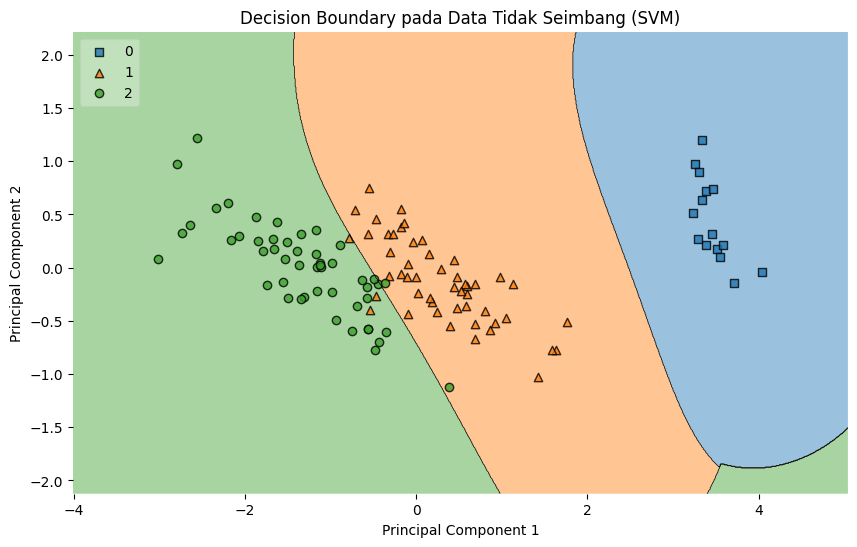

In [17]:
# Definisikan kamus untuk mapping nama spesies ke angka
species_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

# Ambil semua 4 fitur untuk diproses PCA
X_features = df_imbalanced[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_imbalanced = df_imbalanced['species']
y_imbalanced_int = y_imbalanced.map(species_map).values

# Terapkan PCA langsung
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

# Split data hasil PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_imbalanced_int, test_size=0.3, random_state=42, stratify=y_imbalanced_int)

# Latih model SVM pada data PCA
svm_imbalanced_pca = SVC(random_state=42)
svm_imbalanced_pca.fit(X_train, y_train)

# Prediksi dan evaluasi
y_pred = svm_imbalanced_pca.predict(X_test)
print("--- Hasil pada Data Tidak Seimbang (PCA) ---")
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=species_map.keys()))

# Plotting decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_pca, y_imbalanced_int, clf=svm_imbalanced_pca, legend=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary pada Data Tidak Seimbang (SVM)')
plt.show()

## 4. Menyeimbangkan Dataset dengan SMOTE

Sekarang kita akan mengatasi masalah ketidakseimbangan data menggunakan **SMOTE (Synthetic Minority Over-sampling Technique)**. SMOTE bekerja dengan cara membuat sampel sintetis baru untuk kelas minoritas, bukan hanya menduplikasi data yang ada.

**Cara Kerja SMOTE:**
1.  Pilih sebuah sampel dari kelas minoritas secara acak.
2.  Temukan k-tetangga terdekatnya (k-nearest neighbors) yang juga berasal dari kelas minoritas.
3.  Pilih salah satu dari tetangga tersebut secara acak.
4.  Buat sampel sintetis baru pada titik manapun di sepanjang garis yang menghubungkan sampel asli dan tetangga yang dipilih.

Proses ini diulang hingga jumlah sampel kelas minoritas sama dengan jumlah sampel kelas mayoritas, menghasilkan dataset yang seimbang. Kita menerapkan SMOTE pada data fitur asli (sebelum PCA).

In [18]:
# Inisialisasi SMOTE. Cocok untuk data numerik.
smote = SMOTE(random_state=42)

# fit pada data fitur dan target yang belum di-PCA
X_resampled, y_resampled = smote.fit_resample(X_features, y_imbalanced)

# Buat DataFrame baru yang sudah seimbang
df_balanced = pd.DataFrame(X_resampled, columns=X_features.columns)
df_balanced['species'] = y_resampled

print("Distribusi Kelas Setelah SMOTE (Seimbang):")
print(df_balanced['species'].value_counts())

Distribusi Kelas Setelah SMOTE (Seimbang):
species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


## 5. Klasifikasi (SVM Tunggal) & Plot PCA pada Data Seimbang

Langkah selanjutnya adalah melatih dan mengevaluasi model SVM baru menggunakan dataset yang sudah diseimbangkan oleh SMOTE. Prosesnya sama seperti sebelumnya: PCA, split data, training, evaluasi, dan plot.

**Perbandingan Hasil:**
Bandingkan *Classification Report* dari model ini dengan model sebelumnya. Diharapkan, model yang dilatih pada data seimbang akan menunjukkan performa yang lebih baik dan lebih adil di semua kelas, terutama peningkatan metrik *recall* dan *f1-score* untuk kelas 'Iris-setosa'. Batas keputusan yang dihasilkan juga seharusnya lebih baik dalam memisahkan kelas minoritas dari kelas lainnya.

--- Hasil pada Data Seimbang (PCA) ---
Akurasi: 0.9111111111111111

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.82      0.93      0.88        15
 Iris-virginica       0.92      0.80      0.86        15

       accuracy                           0.91        45
      macro avg       0.92      0.91      0.91        45
   weighted avg       0.92      0.91      0.91        45



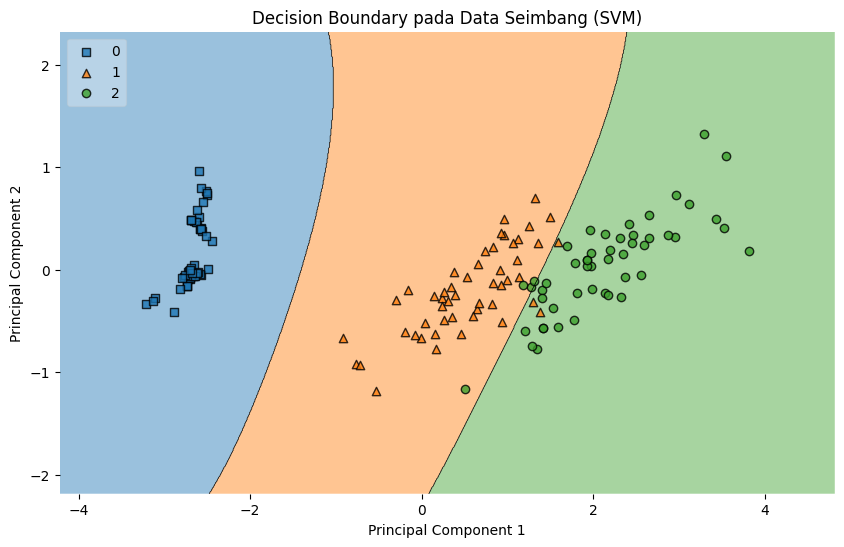

In [19]:
# Ambil semua 4 fitur dari data yang sudah seimbang
X_balanced_features = df_balanced[['sepal length', 'sepal width', 'petal length', 'petal width']]
y_balanced = df_balanced['species']
y_balanced_int = y_balanced.map(species_map).values

# Terapkan PCA langsung
pca_bal = PCA(n_components=2)
X_pca_balanced = pca_bal.fit_transform(X_balanced_features)

# Split data hasil PCA
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_pca_balanced, y_balanced_int, test_size=0.3, random_state=42, stratify=y_balanced_int)

# Latih model SVM pada data PCA
svm_balanced_pca = SVC(random_state=42)
svm_balanced_pca.fit(X_train_b, y_train_b)

# Prediksi dan evaluasi
y_pred_b = svm_balanced_pca.predict(X_test_b)
print("--- Hasil pada Data Seimbang (PCA) ---")
print(f"Akurasi: {accuracy_score(y_test_b, y_pred_b)}")
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_b, target_names=species_map.keys()))

# Plotting decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_pca_balanced, y_balanced_int, clf=svm_balanced_pca, legend=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary pada Data Seimbang (SVM)')
plt.show()

## 6. Klasifikasi dengan Bagging Classifier pada Data Tidak Seimbang

**Bagging (Bootstrap Aggregating)** adalah metode *ensemble learning* yang bertujuan untuk mengurangi varians dan meningkatkan stabilitas model. Cara kerjanya adalah dengan melatih beberapa model (*base estimators*) secara paralel pada subset data yang berbeda (dibuat dengan *sampling with replacement*), lalu menggabungkan prediksi mereka (misalnya, dengan voting).

Di sini, kita akan mencoba `BaggingClassifier` dengan dua *base estimator* yang berbeda:
1.  **Support Vector Machine (SVM):** Model yang kuat namun bisa sensitif terhadap data latih.
2.  **Decision Tree:** Model berbasis aturan yang mempartisi ruang fitur.

Kita akan melatih dan memvisualisasikan kedua versi Bagging ini pada data **tidak seimbang** untuk melihat apakah teknik ensemble ini saja sudah cukup untuk meningkatkan performa.

--- Hasil Bagging SVM pada Data Tidak Seimbang (PCA) ---
Akurasi: 0.9714285714285714

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         5
Iris-versicolor       1.00      0.93      0.97        15
 Iris-virginica       0.94      1.00      0.97        15

       accuracy                           0.97        35
      macro avg       0.98      0.98      0.98        35
   weighted avg       0.97      0.97      0.97        35


--- Hasil Bagging Decision Tree pada Data Tidak Seimbang (PCA) ---
Akurasi: 0.9142857142857143

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         5
Iris-versicolor       0.93      0.87      0.90        15
 Iris-virginica       0.88      0.93      0.90        15

       accuracy                           0.91        35
      macro avg       0.93      0.93      0.93        35
   weighted avg       0

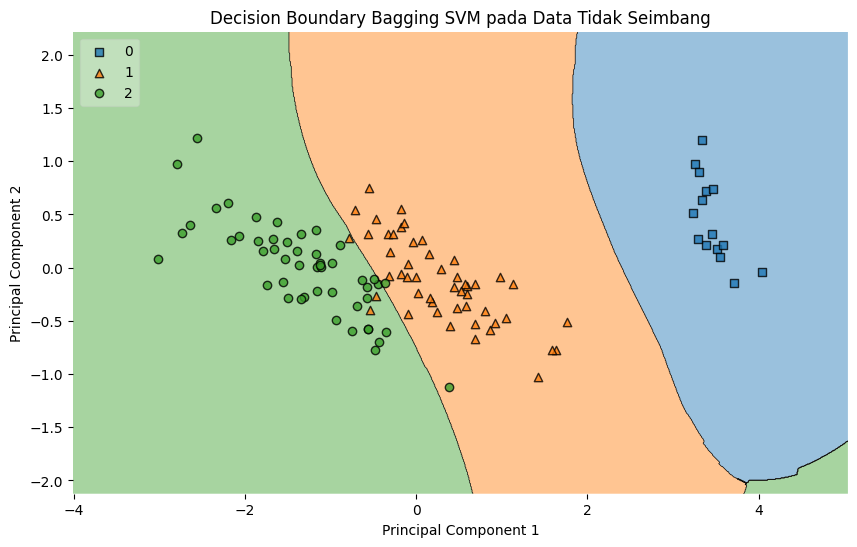

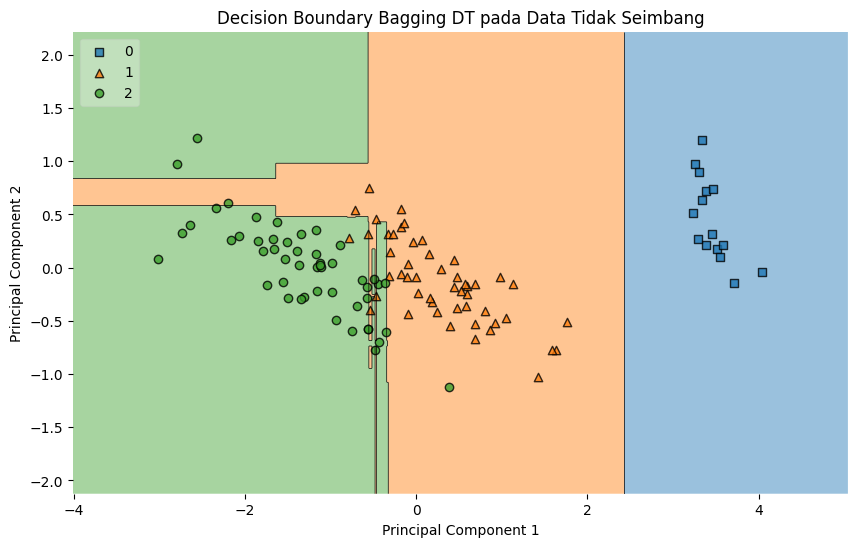

In [20]:
# Inisialisasi Bagging Classifier dengan SVM sebagai base estimator
bagging_svm_imbalanced = BaggingClassifier(estimator=SVC(random_state=42), n_estimators=10, random_state=42)
bagging_svm_imbalanced.fit(X_train, y_train)
y_pred_bag_svm = bagging_svm_imbalanced.predict(X_test)
print("--- Hasil Bagging SVM pada Data Tidak Seimbang (PCA) ---")
print(f"Akurasi: {accuracy_score(y_test, y_pred_bag_svm)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bag_svm, target_names=species_map.keys()))

# Inisialisasi Bagging Classifier dengan Decision Tree sebagai base estimator
bagging_dt_imbalanced = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=10, random_state=42)
bagging_dt_imbalanced.fit(X_train, y_train)
y_pred_bag_dt = bagging_dt_imbalanced.predict(X_test)
print("\n--- Hasil Bagging Decision Tree pada Data Tidak Seimbang (PCA) ---")
print(f"Akurasi: {accuracy_score(y_test, y_pred_bag_dt)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_bag_dt, target_names=species_map.keys()))

# Plotting decision boundary untuk Bagging SVM
plt.figure(figsize=(10, 6))
plot_decision_regions(X_pca, y_imbalanced_int, clf=bagging_svm_imbalanced, legend=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary Bagging SVM pada Data Tidak Seimbang')
plt.show()

# Plotting decision boundary untuk Bagging Decision Tree
plt.figure(figsize=(10, 6))
plot_decision_regions(X_pca, y_imbalanced_int, clf=bagging_dt_imbalanced, legend=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary Bagging DT pada Data Tidak Seimbang')
plt.show()

## 7. Klasifikasi dengan Bagging Classifier pada Data Seimbang

Sekarang, kita gabungkan kedua teknik: **SMOTE** untuk menangani ketidakseimbangan kelas dan **Bagging** untuk meningkatkan stabilitas model. Kita akan melatih dan memvisualisasikan kembali `BaggingClassifier` dengan SVM dan Decision Tree pada data yang sudah diseimbangkan oleh SMOTE. Kombinasi ini seringkali memberikan hasil yang paling robas dan akurat.

--- Hasil Bagging SVM pada Data Seimbang (PCA) ---
Akurasi: 0.9111111111111111

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.82      0.93      0.88        15
 Iris-virginica       0.92      0.80      0.86        15

       accuracy                           0.91        45
      macro avg       0.92      0.91      0.91        45
   weighted avg       0.92      0.91      0.91        45


--- Hasil Bagging Decision Tree pada Data Seimbang (PCA) ---
Akurasi: 0.9111111111111111

Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.82      0.93      0.88        15
 Iris-virginica       0.92      0.80      0.86        15

       accuracy                           0.91        45
      macro avg       0.92      0.91      0.91        45
   weighted avg       0.92      0.9

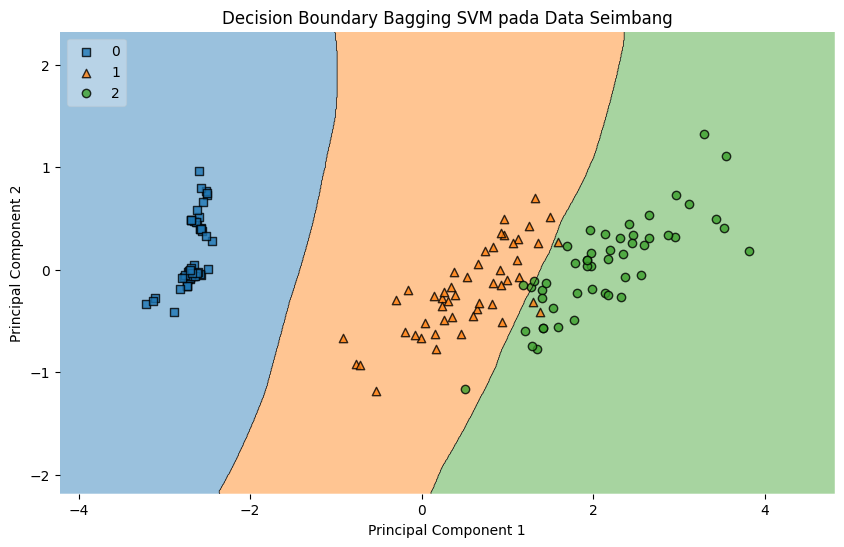

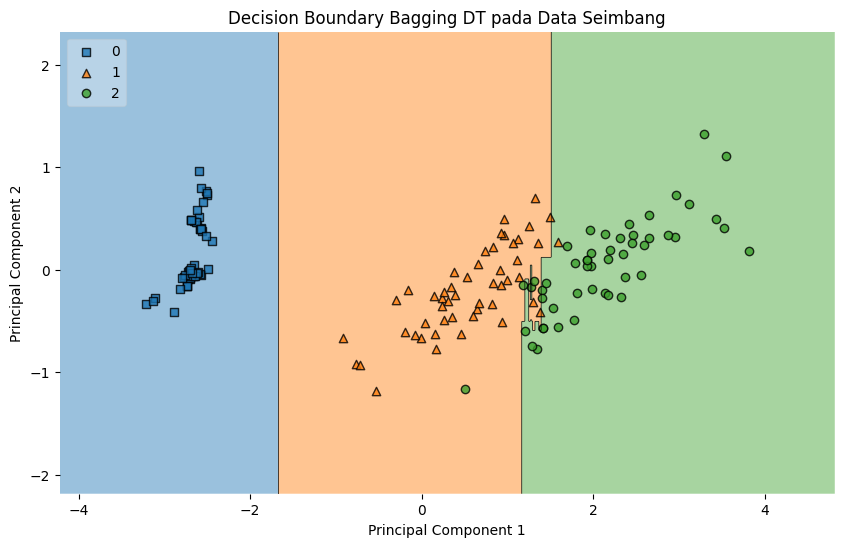

In [21]:
# Latih Bagging SVM pada data seimbang
bagging_svm_balanced = BaggingClassifier(estimator=SVC(random_state=42), n_estimators=10, random_state=42)
bagging_svm_balanced.fit(X_train_b, y_train_b)
y_pred_bag_svm_b = bagging_svm_balanced.predict(X_test_b)
print("--- Hasil Bagging SVM pada Data Seimbang (PCA) ---")
print(f"Akurasi: {accuracy_score(y_test_b, y_pred_bag_svm_b)}")
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_bag_svm_b, target_names=species_map.keys()))

# Latih Bagging Decision Tree pada data seimbang
bagging_dt_balanced = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=10, random_state=42)
bagging_dt_balanced.fit(X_train_b, y_train_b)
y_pred_bag_dt_b = bagging_dt_balanced.predict(X_test_b)
print("\n--- Hasil Bagging Decision Tree pada Data Seimbang (PCA) ---")
print(f"Akurasi: {accuracy_score(y_test_b, y_pred_bag_dt_b)}")
print("\nClassification Report:\n", classification_report(y_test_b, y_pred_bag_dt_b, target_names=species_map.keys()))

# Plotting decision boundary untuk Bagging SVM on balanced data
plt.figure(figsize=(10, 6))
plot_decision_regions(X_pca_balanced, y_balanced_int, clf=bagging_svm_balanced, legend=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary Bagging SVM pada Data Seimbang')
plt.show()

# Plotting decision boundary untuk Bagging Decision Tree on balanced data
plt.figure(figsize=(10, 6))
plot_decision_regions(X_pca_balanced, y_balanced_int, clf=bagging_dt_balanced, legend=2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary Bagging DT pada Data Seimbang')
plt.show()

## 8. Kesimpulan dan Perbandingan

Dari eksperimen di atas, kita dapat menarik beberapa kesimpulan:

1.  **Model pada Data Tidak Seimbang:** Model (SVM tunggal, Bagging SVM, Bagging DT) yang dilatih pada data tidak seimbang menunjukkan performa yang kurang baik pada kelas minoritas ('Iris-setosa'), meskipun akurasi keseluruhannya bisa jadi tinggi. Ini adalah jebakan klasik dari data tidak seimbang.

2.  **Efek SMOTE:** Setelah menerapkan SMOTE, semua model menunjukkan peningkatan signifikan dalam mengenali kelas minoritas. Hal ini terlihat jelas dari metrik *recall* dan *f1-score* untuk 'Iris-setosa' yang meningkat drastis. Akurasi keseluruhan mungkin sedikit turun, namun model menjadi jauh lebih adil dan tidak bias.

3.  **Efek Bagging:** Bagging Classifier, terutama ketika digabungkan dengan SMOTE, memberikan hasil yang sangat baik. Bagging membantu menstabilkan prediksi dan mengurangi *overfitting* yang mungkin terjadi, sementara SMOTE memastikan bahwa model memiliki cukup data dari kelas minoritas untuk dipelajari.

**Kesimpulan Akhir:** Kombinasi antara teknik *oversampling* seperti **SMOTE** dengan metode *ensemble* seperti **Bagging** adalah strategi yang sangat efektif untuk mengatasi masalah klasifikasi pada dataset yang tidak seimbang.